# DIVAnd full analysis

This notebook presents the different steps necessary for the creation of a climatology:
1. ODV data reading.
2. Extraction of bathymetry and creation of mask
3. Data download from other sources and duplicate removal.
4. Quality control.
5. Parameter optimisation.
6. Spatio-temporal interpolation with `DIVAnd`.

In [56]:
using NCDatasets
using PhysOcean
using DataStructures
using DIVAnd
using PyPlot
using Dates
using Statistics
using Random
using Printf

## Configuration
* Define the horizontal, vertical and temporal resolutions.
* Select the variable

In [57]:
dx, dy = 0.125, 0.125
lonr = 10:dx:30
latr = 54:dy:61
timerange = [Date(2010,1,1),Date(2017,12,31)];

depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 60, 
    70, 80, 90, 100, 125, 150, 175, 200, 250, 
    275];
#depthr = [0.,10.,20.];

In [58]:
varname = "Oxygen"
yearlist = [2010:2017];
monthlist = [[7],[8],[9]];
# [1,2],[3,4],[5,6,7],[8,9,10],[11,12]
# [1,2,3,4],[5,6,7],[8,9,10],[11,12]
# [1,2,3,4],[5,6,7],[8,9,10],[11,12]
# [1,2,3],[4,5,6],[7,8,9],[10,11,12]

In [59]:
TS = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);
@show TS;

TS = TimeSelectorYearListMonthList{Vector{UnitRange{Int64}}, Vector{Vector{Int64}}}(UnitRange{Int64}[2010:2017], [[7], [8], [9]])


In [60]:
fname = "C:/Work/DIVAnd/oxy_1960_2021.txt"
obsval,obslon,obslat,obsdepth,obstime,obsid = loadbigfile(fname);
@show(length(obsval));
#plot(obsdepth, obsval, "ko", markersize=0.5);
sel = (Dates.year.(obstime) .== 2015) .& (Dates.month.(obstime) .>= 7) .& (Dates.month.(obstime) .<= 8)
@show(length(obsval[sel]))
#plot(obsdepth[sel], obsval[sel], "ro", markersize=0.5);

┌ Info: Loading data from 'big file' C:/Work/DIVAnd/oxy_1960_2021.txt
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\load_obs.jl:10


length(obsval) = 752800
length(obsval[sel]) = 10807


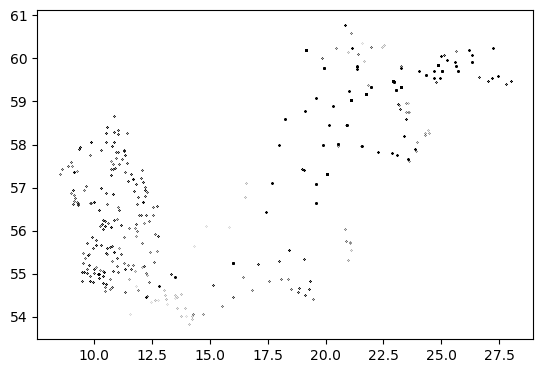

In [61]:
figure("Data")
ax = subplot(1,1,1)
plot(obslon[sel], obslat[sel], "ko", markersize=.1)
aspectratio = 1/cos(mean(latr) * pi/180)
#ax.tick_params("both",labelsize=6)
gca().set_aspect(aspectratio)

Check the extremal values of the observations

In [62]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

              minimum and maximum of obs. dimension 1: (3.339833, 33.0)
              minimum and maximum of obs. dimension 2: (53.4805, 65.7302)
              minimum and maximum of obs. dimension 3: (0.0, 453.6)
              minimum and maximum of obs. dimension 4: (DateTime("1960-08-01T00:00:00"), DateTime("2021-12-13T00:00:00"))
                          minimum and maximum of data: (-38.984886, 14.4)


┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\obsstat.jl:78


## 2. Extract the bathymetry
It is used to delimit the domain where the interpolation is performed.

### 2.1 Choice of bathymetry
Modify `bathname` according to the resolution required.

In [63]:
bathname = "../data/gebco_30sec_8.nc"
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download",bathname)
else
    @info("Bathymetry file already downloaded")
end
bathisglobal = true

┌ Info: Bathymetry file already downloaded
└ @ Main In[63]:5


true

In [64]:
@time bx,by,b = load_bath(bathname,true,lonr,latr);

  0.007011 seconds (589 allocations: 1.007 MiB)


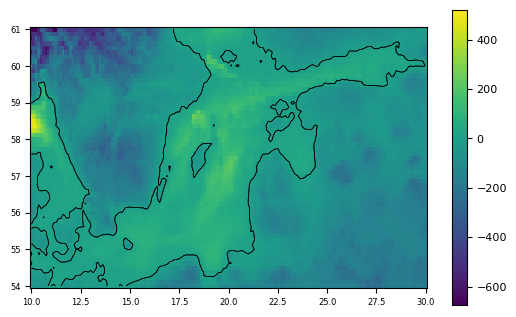

In [65]:
figure("Bathymetry")
ax = subplot(1,1,1)
pcolor(bx, by, permutedims(b, [2,1]));
colorbar(orientation="vertical", shrink=0.8).ax.tick_params(labelsize=8)
contour(bx, by, permutedims(b, [2,1]), [0, 0.1], colors="k", linewidths=.5)
gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)

### 2.2 Create mask
* False for sea        
* True for land

In [66]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end
@show size(mask)

size(mask) = (161, 57, 25)


(161, 57, 25)

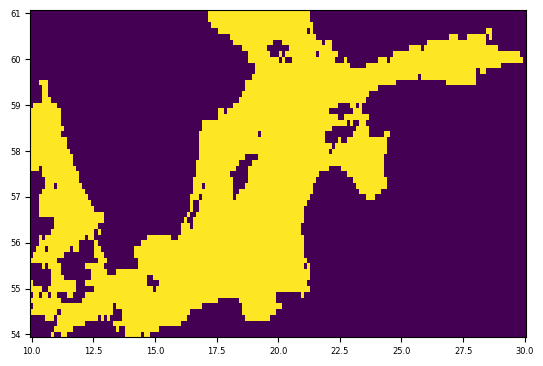

In [67]:
figure("Mask")
ax = subplot(1,1,1)
gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)
pcolor(bx,by, transpose(mask[:,:,1])); 

## 4. Quality control
We check the salinity value.     
Adapt the criteria to your region and variable.

In [68]:
sel = (obsval .<= 12) .& (obsval .>= -10);

In [69]:
obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsid = obsid[sel];

## 5. Analysis parameters

### Modify data weight 
⌛⌛⌛       
Compute the new weights that takes into account close points.     
If the dataset is large, this can take a few minutes.     
The maximal and mean values provide an indication of the spatial proximity between the data.    
If you apply this technique, you need to adapt `epsilon2`:

In [ ]:
#@time rdiag=1.0./DIVAnd.weight_RtimesOne((obslon,obslat),(0.03,0.03));
#@show maximum(rdiag),mean(rdiag)

### Correlation lengths and noise-to-signal ratio
We will use the function `diva3D` for the calculations.     
With this function, the correlation length has to be defined in meters, not in degrees.

In [70]:
sz = (length(lonr),length(latr),length(depthr));
lenx = fill(40_000.,sz)   # 100 km
leny = fill(40_000.,sz)   # 100 km
lenz = fill(10.,sz);      # 25 m 
len = (lenx, leny, lenz);
epsilon2 = 0.1;
#epsilon2 = epsilon2 * rdiag;

### Output file name

In [72]:
outputdir = "./output/"
if !isdir(outputdir)
    mkpath(outputdir)
end
filename = joinpath(outputdir, "Water_body_$(replace(varname," "=>"_")).nc")

"./output/Water_body_Oxygen.nc"

## 6. Metadata and attributes
Edit the different fields according to the project, the authors etc.     
This is used for the netCDF file but also for the XML needed for the Sextant catalog.

In [75]:
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
    "project" => "SeaDataNet",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    #"production" => "Diva group",

    # Name and emails from authors
    "Author_e-mail" => ["Your Name1 <name1@example.com>", "Other Name <name2@example.com>"],

    # Source of the observation
    "source" => "ICES",

    # Additional comment
    "comment" => "Preprocessed only autumn",

    # SeaDataNet Vocabulary P35 URN
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    # example: SDN:P35::WATERTEMP
    "parameter_keyword_urn" => "SDN:P35::EPC00001",

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    # example: ["SDN:P02::TEMP"]
    "search_keywords_urn" => ["SDN:P02::DOXY"],

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    # example: ["SDN:C19::3_1"]
    "area_keywords_urn" => ["SDN:C19::3_3"],

    "product_version" => "1.0",
    
    "product_code" => "something-to-decide",
    
    # bathymetry source acknowledgement
    # see, e.g.
    # * EMODnet Bathymetry Consortium (2016): EMODnet Digital Bathymetry (DTM).
    # https://doi.org/10.12770/c7b53704-999d-4721-b1a3-04ec60c87238
    # 
    # taken from
    # http://www.emodnet-bathymetry.eu/data-products/acknowledgement-in-publications
    #
    # * The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003
    #
    # taken from
    # https://www.bodc.ac.uk/projects/data_management/international/gebco/gebco_digital_atlas/copyright_and_attribution/
        
    "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

    # NetCDF CF standard name
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    # example "standard_name" = "sea_water_temperature",
    "netcdf_standard_name" => "sea_water_dissolved_oxygen",

    "netcdf_long_name" => "sea water dissolved oxygen",

    "netcdf_units" => "1",

    # Abstract for the product
    "abstract" => "...",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgement" => "...",

    "documentation" => "https://doi.org/doi_of_doc",

    # Digital Object Identifier of the data product
    "doi" => "...");

SeaDataNet global attributes:

In [76]:
ncglobalattrib, ncvarattrib = SDNMetadata(metadata, filename, varname, lonr, latr)

(OrderedDict("project" => "SeaDataNet", "institution" => "University of Liège, GeoHydrodynamics and Environment Research", "institution_urn" => "SDN:EDMO::1579", "Author_e-mail" => "Your Name1 <name1@example.com>, Other Name <name2@example.com>", "source" => "ICES", "comment" => "Preprocessed only autumn", "parameter_keyword" => "Water body salinity", "parameter_keyword_urn" => "SDN:P35::EPC00001", "search_keywords" => "Dissolved oxygen parameters in the water column", "search_keywords_urn" => "SDN:P02::DOXY"…), OrderedDict("units" => "1", "standard_name" => "sea_water_dissolved_oxygen", "long_name" => "sea water dissolved oxygen"))

## 7. Analysis

Remove the result file before running the analysis, otherwise you'll get the message     
```julia
NCDatasets.NetCDFError(13, "Permission denied")
```

In [81]:
if isfile(filename)
    rm(filename) # delete the previous analysis
    @info "Removing file $filename"
end

### 7.1 Plotting function
Define a plotting function that will be applied for each time index and depth level.     
All the figures will be saved in a selected directory.

In [82]:
figdir = "./output/figures/"
if ~(isdir(figdir))
    mkdir(figdir)
else
    @info("Figure directory already exists")
end

┌ Info: Figure directory already exists
└ @ Main In[82]:5


In [83]:
function plotres(timeindex,sel,fit,erri)
    tmp = copy(fit)
    nx,ny,nz = size(tmp)
    for i in 1:nz
        figure("OXY-Data")
        ax = subplot(1,1,1)
        ax.tick_params("both",labelsize=6)
        ylim(53., 60.);
        xlim(10, 30.0);
        title("Depth: $(depthr[i]) \n Time index: $(timeindex)", fontsize=6)
        pcolor(lonr.-dx/2.,latr.-dy/2, permutedims(tmp[:,:,i], [2,1]);
               vmin = 0, vmax = 12)
        colorbar(extend="both", orientation="vertical", shrink=0.8).ax.tick_params(labelsize=8)

        contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
        aspectratio = 1/cos(mean(latr) * pi/180)
        gca().set_aspect(aspectratio)
        
        figname = varname * @sprintf("_%02d",i) * @sprintf("_%03d.png",timeindex)
        PyPlot.savefig(joinpath(figdir, figname), dpi=600, bbox_inches="tight");
        PyPlot.close_figs()
    end
end

plotres (generic function with 1 method)

### 7.2 Create the gridded fields using `diva3d`
Here only the noise-to-signal ratio is estimated.     
Set `fitcorrlen` to `true` to also optimise the correlation length.

In [85]:
@time dbinfo = diva3d((lonr,latr,depthr,TS),
    (obslon,obslat,obsdepth,obstime), obsval,
    len, epsilon2,
    filename,varname,
    bathname=bathname,
    plotres = plotres,
    mask = mask,
    fitcorrlen = false,
    niter_e = 2,
    ncvarattrib = ncvarattrib,
    ncglobalattrib = ncglobalattrib,
    surfextend = true
    );

┌ Info: Creating netCDF file ./output/Water_body_Oxygen.nc
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:374
┌ Info: Time step 1 / 3
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:427
┌ Info: scaled correlation length (min,max) in dimension 1: (40000.0, 40000.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 2: (40000.0, 40000.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Info: scaled correlation length (min,max) in dimension 3: (10.0, 10.0)
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\diva.jl:612
┌ Warning: resolution (7.5) is too coarse for correlation length 10.0 in dimension 3 at indices CartesianIndex(47, 4, 8) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd C:\Users\a001109\.julia\packages\DIVAnd\Iwjb1\src\utils.jl:18
┌ Info: 

321.690190 seconds (162.66 M allocations: 54.195 GiB, 6.49% gc time, 0.00% compilation time)


Example of results: salinity at 20 meters for the April-May-June period.

<img src="./Adriatic/figures/Salinity_02_002.png" width="450px">

Save the observation metadata in the NetCDF file.      

In [ ]:
DIVAnd.saveobs(filename,(obslon,obslat,obsdepth,obstime),obsid);

## 8. Apply a posteriori quality control
We can use the structure `dbinfo`.
histogram for quality flags

## 9. XML metadata

For DIVAnd analysis using SeaDataCloud/EMODnet-Chemistry data, one can create a XML description for the product for Sextant

Name of the project:
* "SeaDataCloud" or 
* "EMODNET-chemistry"

In [ ]:
project = "SeaDataCloud";
project = "EMODNET-chemistry"

Download CDI list

In [ ]:
cdilist = "./CDI-list-export.zip"

if !isfile(cdilist)
   download("http://emodnet-chemistry.maris2.nl/download/export.zip", cdilist)
end

If `ignore_errors` is `false` (default), then a missing CDI will stop the creatation of the XML metadata.

In [ ]:
ignore_errors = true

# File name based on the variable (but all spaces are replaced by underscores)
xmlfilename = "Water_body_$(replace(varname," "=>"_")).4Danl.xml"

Uncomment the following line of you are using SeaDataCloud or EMODnet-Chemistry data.

In [ ]:
# generate a XML file for Sextant catalog
divadoxml(filename,varname,project,cdilist,xmlfilename,
          ignore_errors = ignore_errors)